<a href="https://colab.research.google.com/github/ymuto0302/PJ2025/blob/main/LR_scheduling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 学習率スケジューリング
題材は CIFAR-10 データセット

=== CIFAR-10 を使って学習率スケジューリングのデモをやるよ!! ===

使用デバイス: cuda
CIFAR-10データセットをダウンロード中...
Training with No Scheduler...
  Epoch 10: Loss=1.9096, Train Acc=30.10%, Test Acc=29.95%, LR=0.010000
  Epoch 20: Loss=1.6752, Train Acc=38.83%, Test Acc=39.30%, LR=0.010000
  Epoch 30: Loss=1.5744, Train Acc=42.66%, Test Acc=39.90%, LR=0.010000
  Epoch 40: Loss=1.4709, Train Acc=46.67%, Test Acc=46.45%, LR=0.010000
  Epoch 50: Loss=1.4149, Train Acc=48.67%, Test Acc=48.70%, LR=0.010000
  Epoch 60: Loss=1.3527, Train Acc=51.15%, Test Acc=52.50%, LR=0.010000
  Epoch 70: Loss=1.2941, Train Acc=53.36%, Test Acc=52.10%, LR=0.010000
  Epoch 80: Loss=1.2448, Train Acc=54.93%, Test Acc=54.15%, LR=0.010000
  Epoch 90: Loss=1.2005, Train Acc=56.85%, Test Acc=55.90%, LR=0.010000
  Epoch 100: Loss=1.1620, Train Acc=58.11%, Test Acc=56.75%, LR=0.010000
Training with StepLR...
  Epoch 10: Loss=1.9476, Train Acc=28.89%, Test Acc=31.05%, LR=0.005000
  Epoch 20: Loss=1.8095, Train Acc=33.98%, Test Acc=35.00%, LR=0.002500

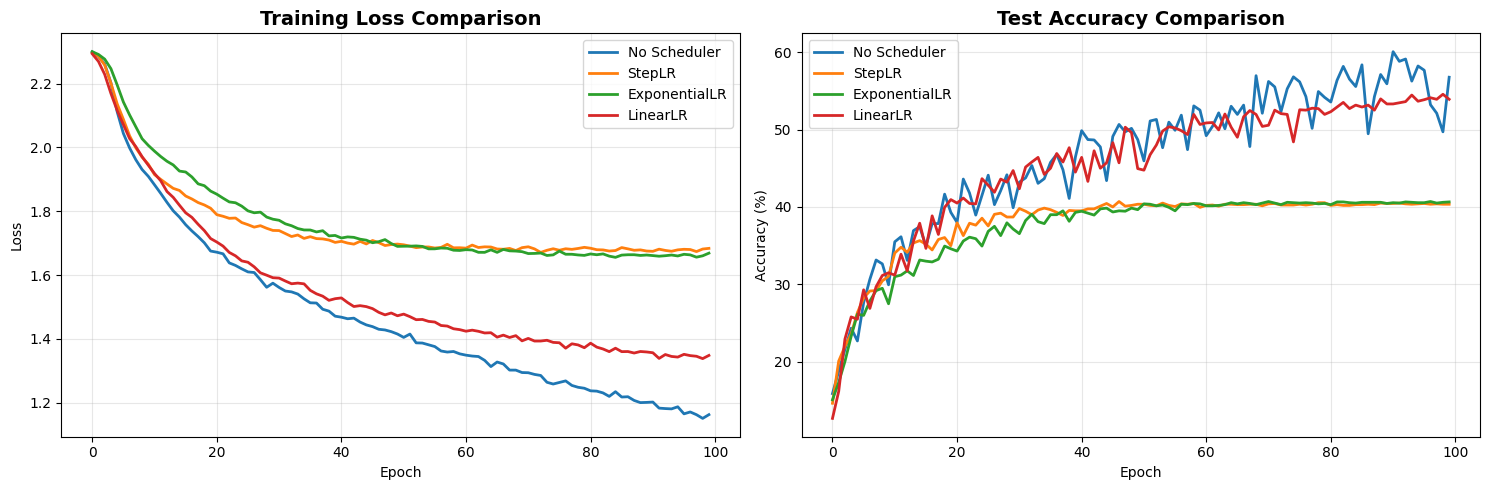

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import *
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

print("=== CIFAR-10 を使って学習率スケジューリングのデモをやるよ!! ===\n")

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用デバイス: {device}")

# CIFAR-10用のCNNモデル定義
class CIFAR10Net(nn.Module):
    def __init__(self):
        super(CIFAR10Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# データセットの準備
def prepare_cifar10_data():
    """CIFAR-10データセットの準備"""

    # 訓練用変換 (データ拡張を含む変換)
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    # 検証用変換（データ拡張なし）
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    # データセットをダウンロード
    print("CIFAR-10データセットをダウンロード中...")
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=train_transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                               download=True, transform=test_transform)

    # (メモ) 計算時間短縮のため，小さなサブセットを作成
    train_subset = Subset(train_dataset, range(0, 10000))  # 10,000サンプル
    test_subset = Subset(test_dataset, range(0, 2000))     # 2,000サンプル

    # データローダー作成
    train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_subset, batch_size=128, shuffle=False, num_workers=2)

    return train_loader, test_loader

# 2. 実際の学習における効果を比較
def compare_training_with_schedulers():
    """異なるスケジューラーでのCIFAR-10学習効果を比較"""

    # データ準備
    train_loader, test_loader = prepare_cifar10_data()

    # 学習設定
    epochs = 100  # (メモ) 動作検証する場合，小さめに設定
    initial_lr = 0.01

    # 異なるスケジューラーでの学習
    scheduler_configs = {
        'No Scheduler': None,
        'StepLR': {'class': StepLR, 'params': {'step_size': 10, 'gamma': 0.5}},
        'ExponentialLR': {'class': ExponentialLR, 'params': {'gamma': 0.95}},
        'LinearLR': {'class': LinearLR, 'params': {'start_factor': 1.0, 'end_factor': 0.1, 'total_iters': epochs}}
    }

    results = {}

    for name, config in scheduler_configs.items():
        print(f"Training with {name}...")

        # モデル，損失関数，オプティマイザを初期化
        model = CIFAR10Net().to(device)
        criterion = nn.CrossEntropyLoss()
        #optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9, weight_decay=5e-4)
        optimizer = optim.SGD(model.parameters(), lr=initial_lr)
        #optimizer = optim.Adam(model.parameters(), lr=initial_lr)

        # スケジューラー設定
        if config is not None:
            scheduler = config['class'](optimizer, **config['params'])
        else:
            scheduler = None

        # 学習履歴
        train_loss_history = []
        train_acc_history = []
        test_acc_history = []
        lr_history = []

        # 学習ループ
        for epoch in range(epochs):
            # 訓練フェーズ
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)

                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                total_train += target.size(0)
                correct_train += (predicted == target).sum().item()

            # 検証フェーズ
            model.eval()
            correct_test = 0
            total_test = 0

            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    _, predicted = torch.max(output.data, 1)
                    total_test += target.size(0)
                    correct_test += (predicted == target).sum().item()

            # スケジューラー更新
            if scheduler is not None:
                scheduler.step()

            # 履歴記録
            epoch_loss = running_loss / len(train_loader)
            train_acc = 100. * correct_train / total_train
            test_acc = 100. * correct_test / total_test
            current_lr = optimizer.param_groups[0]['lr']

            train_loss_history.append(epoch_loss)
            train_acc_history.append(train_acc)
            test_acc_history.append(test_acc)
            lr_history.append(current_lr)

            if (epoch+1) % 10 == 0:
                print(f'  Epoch {epoch+1:2d}: Loss={epoch_loss:.4f}, Train Acc={train_acc:.2f}%, Test Acc={test_acc:.2f}%, LR={current_lr:.6f}')

        results[name] = {
            'train_loss_history': train_loss_history,
            'train_acc_history': train_acc_history,
            'test_acc_history': test_acc_history,
            'lr_history': lr_history,
            'final_test_acc': test_acc_history[-1]
        }

    # 結果をプロット
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 訓練損失の変化
    for name, result in results.items():
        ax1.plot(result['train_loss_history'], label=name, linewidth=2)
    ax1.set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # テスト精度の変化
    for name, result in results.items():
        ax2.plot(result['test_acc_history'], label=name, linewidth=2)
    ax2.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 結果のサマリー
    '''
    print("\n=== CIFAR-10 Training Results Summary ===")
    for name, result in results.items():
        print(f"{name:20s}: Final Test Accuracy = {result['final_test_acc']:.2f}%")
    '''

# 4. CIFAR-10クラス名の定義
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# メイン実行
compare_training_with_schedulers()
